In [76]:
pip install weaviate-client

In [77]:
# @title LIBS

from abc import ABC, abstractmethod
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses as loss_functions
from torch.utils.data import DataLoader
from datasets import load_dataset
from typing import List, Tuple, Dict, Optional
from tqdm import tqdm
import json
import re
import matplotlib.pyplot as plt

import weaviate
from weaviate.classes.init import Auth
from weaviate.classes.config import Property, DataType
from weaviate.classes.query import MetadataQuery
from weaviate.exceptions import WeaviateStartUpError

import os
os.environ["WANDB_DISABLED"] = "true"

In [78]:
# @title Config

class Config:
    """
    Configuration class for device, model, fine-tuning, and Weaviate settings.

    Attributes:
        device (str): Compute device ("cuda" if GPU available, else "cpu").
        model_name (str): Pretrained SentenceTransformer model name.
        batch_size (int): Fine-tuning batch size.
        epochs (int): Number of training epochs.
        loss_fn: Loss function class for fine-tuning (MultipleNegativesRankingLoss).
        weaviate_batch_size (int): Batch size for Weaviate insertion.
        weaviate_path (str): Path for Weaviate embedded persistence.
        vector_index_config: HNSW vector index configuration for Weaviate.
        func_name_embedding (bool): Optional feature flag for function name embeddings.
    """

    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    model_name: str = "sentence-transformers/all-MiniLM-L6-v2"

    # Fine-tuning
    batch_size: int = 16
    epochs: int = 1
    loss_fn = loss_functions.MultipleNegativesRankingLoss

    # Weaviate
    weaviate_batch_size: int = 256
    weaviate_path: str = "./weaviate_data"

    vector_index_config = weaviate.classes.config.Configure.VectorIndex.hnsw(
        ef_construction=64,
        ef=64,
        max_connections=32,
        vector_cache_max_objects=1000,
        flat_search_cutoff=4000,
        dynamic_ef_min=100,
        dynamic_ef_max=500,
        dynamic_ef_factor=8,
    )

    # Bonus
    func_name_embedding: bool = False

In [79]:
# @title Weaviate DB
# ============================================================================
# WEAVIATE CLIENT
# ============================================================================

class WeaviateDB:
    """
    Wrapper around Weaviate database operations.

    Provides methods for:
    - Connecting to an embedded or local Weaviate instance
    - Initializing collections with schema
    - Batch inserting document vectors
    - Closing the client connection
    """

    def __init__(self):
        """Initialize a WeaviateDB instance and create a client connection."""
        self.client = self.get_weaviate_client()

    # ----------------------------------------------------------------------
    def get_weaviate_client(self) -> weaviate.Client:
        """
        Connect to a Weaviate instance.

        Attempts to start an embedded Weaviate instance using the configured
        persistence path. If an instance is already running, it connects
        to the existing local instance instead.

        Returns:
            weaviate.Client: Active Weaviate client instance.
        """
        try:
            client = weaviate.connect_to_embedded(
                persistence_data_path=Config.weaviate_path
            )
            print("✅ Started new embedded Weaviate instance.")
            return client

        except WeaviateStartUpError as e:
            if "already listening on ports" in str(e):
                client = weaviate.connect_to_local(port=8079, grpc_port=50050)
                print("🔄 Connected to existing embedded Weaviate instance.")
                return client
            raise

    # ----------------------------------------------------------------------
    def initialize_collection(
        self,
        collection_name: str,
        doc_type: type["Document"],
        client: weaviate.Client,
    ) -> None:
        """
        Initialize (create or reset) a Weaviate collection for a document type.

        Args:
            collection_name (str): Name of the collection to create.
            doc_type (type[Document]): Document class defining schema.
            client (weaviate.Client): Active Weaviate client.

        Notes:
            If the collection already exists, it will be deleted first.
        """
        if client.collections.exists(collection_name):
            print(f"🗑️  Deleting existing collection: {collection_name}")
            client.collections.delete(collection_name)

        print(f"✨ Creating collection: {collection_name}")
        schema = doc_type.get_weaviate_schema()

        client.collections.create(
            name=collection_name,
            vectorizer_config=None,
            properties=schema,
            vector_index_config=Config.vector_index_config,
        )
        print("✅ Collection ready")

    # ----------------------------------------------------------------------
    def batch_insert(
        self,
        collection: weaviate.collections.Collection,
        documents: List["Document"],
        vectors: np.ndarray,
    ) -> None:
        """
        Insert a batch of documents and precomputed vectors into a collection.

        Args:
            collection (weaviate.collections.Collection): Target Weaviate collection.
            documents (list[Document]): List of document objects to insert.
            vectors (np.ndarray): Array of vector embeddings (same length as documents).
        """
        with collection.batch.fixed_size(batch_size=Config.weaviate_batch_size) as batch:
            for doc, vector in tqdm(
                zip(documents, vectors),
                total=len(documents),
                desc="Uploading",
            ):
                batch.add_object(
                    properties=doc.to_weaviate_properties(),
                    vector=vector,
                )

    # ----------------------------------------------------------------------
    def close(self) -> None:
        """
        Close the Weaviate client connection.

        Safely terminates the active client session and releases any resources.
        """
        if hasattr(self, "client") and self.client is not None:
            self.client.close()
            print("🔒 Connection closed")


In [80]:
# @title Document Schemas
# ============================================================================
# DOCUMENT ABC AND IMPLEMENTATIONS
# ============================================================================

class Document:
    """Universal document class with id and body (can be instantiated directly)"""

    def __init__(self, doc_id: int, body: str):
        self.doc_id = doc_id
        self.body = body

    def get_text_for_embedding(self) -> str:
        """Return text to be embedded (for vector representation)"""
        return self.body

    def to_weaviate_properties(self) -> Dict:
        """Convert document to Weaviate properties"""
        return {
            "doc_id": self.doc_id,
            "body": self.body,
            "doc_type": "universal"
        }

    def get_display_text(self) -> str:
        """Return formatted text for display"""
        return f"{self.doc_id}: {self.body}"

    @staticmethod
    def get_weaviate_schema() -> List:
        """Return Weaviate schema properties for this document type"""
        return [
            Property(name="doc_id", data_type=DataType.INT),
            Property(name="body", data_type=DataType.TEXT),
            Property(name="doc_type", data_type=DataType.TEXT),
        ]

    @classmethod
    def from_weaviate_object(cls, obj) -> 'Document':
        """Create document from Weaviate object"""
        props = obj.properties
        return cls(
            doc_id=props["doc_id"],
            body=props["body"]
        )


class CodeDocument(Document):
    """Document representing a code snippet"""

    def __init__(self, doc_id: int, code: str, language: str = "python"):
        self.doc_id = doc_id
        self.code = code
        self.language = language

    def get_text_for_embedding(self) -> str:
        """Code is embedded directly"""
        return self.code

    def to_weaviate_properties(self) -> Dict:
        return {
            "doc_id": self.doc_id,
            "code": self.code,
            "language": self.language,
            "doc_type": "code"
        }

    def get_display_text(self) -> str:
        return f"[{self.language}] {self.code[:100]}..."

    @staticmethod
    def get_weaviate_schema() -> List:
        return [
            Property(name="doc_id", data_type=DataType.INT),
            Property(name="code", data_type=DataType.TEXT),
            Property(name="language", data_type=DataType.TEXT),
            Property(name="doc_type", data_type=DataType.TEXT),
        ]

    @classmethod
    def from_weaviate_object(cls, obj) -> 'CodeDocument':
        props = obj.properties
        return cls(
            doc_id=props["doc_id"],
            code=props["code"],
            language=props.get("language", "python")
        )


class ArxivDocument(Document):
    """Document representing a scientific paper from ArXiv"""

    def __init__(self, doc_id: int, title: str, abstract: str,
                 categories: List[str] = None):
        self.doc_id = doc_id
        self.title = title
        self.abstract = abstract
        self.categories = categories or []

    def get_text_for_embedding(self) -> str:
        """Combine title and abstract for embedding"""
        return f"{self.title} {self.abstract}"

    def to_weaviate_properties(self) -> Dict:
        return {
            "doc_id": self.doc_id,
            "title": self.title,
            "abstract": self.abstract,
            "categories": self.categories,
            "doc_type": "arxiv"
        }

    def get_display_text(self) -> str:
        cats = ", ".join(self.categories[:3]) if self.categories else "N/A"
        return f"📄 {self.title}\n   {self.abstract[:100]}...\n   🏷️ {cats}"

    @staticmethod
    def get_weaviate_schema() -> List:
        return [
            Property(name="doc_id", data_type=DataType.INT),
            Property(name="title", data_type=DataType.TEXT),
            Property(name="abstract", data_type=DataType.TEXT),
            Property(name="categories", data_type=DataType.TEXT_ARRAY),
            Property(name="doc_type", data_type=DataType.TEXT),
        ]

    @classmethod
    def from_weaviate_object(cls, obj) -> 'ArxivDocument':
        props = obj.properties
        return cls(
            doc_id=props["doc_id"],
            title=props["title"],
            abstract=props["abstract"],
            categories=props.get("categories", [])
        )

DOC_TYPE_MAP = {
        "code": CodeDocument,
        "arxiv": ArxivDocument,
        "universal": Document,
    }

In [81]:
# @title Search Engine
# ============================================================================
# UNIFIED SEARCH ENGINE
# ============================================================================

class UnifiedSearchEngine:
    """Single search engine that handles multiple document types using a unified Weaviate backend."""

    def __init__(
        self,
        collection_name: str,
        documents: List["Document"],
        model: Optional[SentenceTransformer] = None
    ):
        """
        Initialize the unified search engine.

        Args:
            collection_name (str): Name of the Weaviate collection to use.
            documents (List[Document]): List of document objects to be indexed.
            model (Optional[SentenceTransformer]): Optional pre-initialized embedding model.
                If not provided, a default model will be loaded using `Config.model_name`.

        Attributes:
            model (SentenceTransformer): The embedding model used for encoding text.
            documents (List[Document]): Documents managed by this search engine.
            client (weaviate.Client): Active Weaviate client instance.
            collection_name (str): Name of the associated Weaviate collection.
            collection (Optional[weaviate.collections.Collection]): Active Weaviate collection.
        """
        self.model = model if model else SentenceTransformer(Config.model_name, device=Config.device)
        self.documents = documents
        self.client = db.get_weaviate_client()
        self.collection_name = collection_name
        self.collection = None

        self._index_documents()

    # ----------------------------------------------------------------------
    def _index_documents(self, batch_size: int = Config.weaviate_batch_size) -> None:
        """
        Index all provided documents into the configured Weaviate collection.

        Args:
            batch_size (int): Number of documents processed per embedding/insertion batch.

        Raises:
            ValueError: If `self.documents` is empty or collection initialization fails.
        """
        if not self.documents:
            raise ValueError("No documents to index")

        if self.collection is None:
            db.initialize_collection(self.collection_name, type(self.documents[0]), self.client)
            self.collection = self.client.collections.get(self.collection_name)

        print(f"\n📥 Indexing {len(self.documents)} documents...")

        texts = [doc.get_text_for_embedding() for doc in self.documents]
        vectors = self.model.encode(
            texts,
            batch_size=batch_size,
            convert_to_numpy=True,
            show_progress_bar=True
        ).astype(np.float32)

        db.batch_insert(self.collection, self.documents, vectors)
        print(f"✅ Successfully indexed {len(self.documents)} documents")

    # ----------------------------------------------------------------------
    def search(self, query: str, top_k: int = 10) -> List[Tuple["Document", float]]:
        """
        Perform semantic search over indexed documents.

        Args:
            query (str): Input query text.
            top_k (int): Number of most similar documents to return.

        Returns:
            List[Tuple[Document, float]]: A list of tuples containing:
                - The retrieved `Document` instance.
                - Its similarity score (1 - distance).

        Raises:
            ValueError: If no collection is initialized or indexed.
        """
        if self.collection is None:
            raise ValueError("No collection initialized. Index documents first.")

        # Encode query
        query_vector = self.model.encode(query).astype(np.float32)

        response = self.collection.query.near_vector(
            near_vector=query_vector,
            limit=top_k,
            return_metadata=MetadataQuery(distance=True)
        )

        results: List[Tuple["Document", float]] = []
        for obj in response.objects:
            doc_cls = DOC_TYPE_MAP.get(obj.properties.get("doc_type", "unknown"), Document)
            doc = doc_cls.from_weaviate_object(obj)

            similarity = 1 - obj.metadata.distance
            results.append((doc, similarity))

        return results

In [82]:
# @title METRICS
# ============================================================================
# EVALUATION METRICS
# ============================================================================

class RankingMetrics:
    """Ranking metrics for information retrieval"""

    @staticmethod
    def recall_at_k(retrieved_ids: List[int], relevant_ids: List[int], k: int = 10) -> float:
        """Recall@k: proportion of relevant items in top-k"""
        if not relevant_ids:
            return 0.0
        retrieved_k = set(retrieved_ids[:k])
        relevant_set = set(relevant_ids)
        hits = len(retrieved_k.intersection(relevant_set))
        return hits / len(relevant_set)

    @staticmethod
    def mrr_at_k(retrieved_ids: List[int], relevant_ids: List[int], k: int = 10) -> float:
        """Mean Reciprocal Rank@k"""
        relevant_set = set(relevant_ids)
        for rank, doc_id in enumerate(retrieved_ids[:k], start=1):
            if doc_id in relevant_set:
                return 1.0 / rank
        return 0.0

    @staticmethod
    def ndcg_at_k(retrieved_ids: List[int], relevant_ids: List[int], k: int = 10) -> float:
        """Normalized Discounted Cumulative Gain@k"""
        relevant_set = set(relevant_ids)

        dcg = sum(
            (1.0 if doc_id in relevant_set else 0.0) / np.log2(rank + 1)
            for rank, doc_id in enumerate(retrieved_ids[:k], start=1)
        )

        idcg = sum(1.0 / np.log2(rank + 1)
                   for rank in range(1, min(len(relevant_ids), k) + 1))

        return dcg / idcg if idcg > 0 else 0.0

    @staticmethod
    def evaluate(engine: UnifiedSearchEngine,
                 queries: List[str],
                 relevant_docs: List[List[int]],
                 k: int = 10) -> Dict[str, float]:
        """Evaluate search engine on multiple queries"""
        recall_scores = []
        mrr_scores = []
        ndcg_scores = []

        for query, relevant_ids in tqdm(zip(queries, relevant_docs),
                                        total=len(queries),
                                        desc="Evaluating"):
            results = engine.search(query, top_k=k)
            retrieved_ids = [doc.doc_id for doc, _ in results]

            recall_scores.append(
                RankingMetrics.recall_at_k(retrieved_ids, relevant_ids, k)
            )
            mrr_scores.append(
                RankingMetrics.mrr_at_k(retrieved_ids, relevant_ids, k)
            )
            ndcg_scores.append(
                RankingMetrics.ndcg_at_k(retrieved_ids, relevant_ids, k)
            )

        return {
            f'Recall@{k}': np.mean(recall_scores),
            f'MRR@{k}': np.mean(mrr_scores),
            f'NDCG@{k}': np.mean(ndcg_scores)
        }

In [83]:
# @title Fine-tuning
# ============================================================================
# FINE-TUNING
# ============================================================================

def fine_tune_model(
    base_model: SentenceTransformer,
    train_data: List[Dict],
    num_epochs: int = 1,
    batch_size: int = 16,
    output_path: str = "./finetuned_model",
) -> Tuple[SentenceTransformer, List[float]]:
    """
    Fine-tune using MultipleNegativesRankingLoss

    Args:
        base_model: Pre-trained model
        train_data: List of {"query": str, "code": str}
        num_epochs: Training epochs
        batch_size: Batch size
        output_path: Save path

    Returns:
        (finetuned_model, loss_history)
    """

    print(f"\n🔧 Fine-tuning on {len(train_data)} examples...")
    print(f"   Loss: MultipleNegativesRankingLoss")
    print(f"   Batch size: {batch_size}, Epochs: {num_epochs}")

    train_examples = [
        InputExample(texts=[item['query'], item['code']])
        for item in train_data
    ]

    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)

    class TrackingLoss(Config.loss_fn):
        def __init__(self, model, tracker):
            super().__init__(model)
            self.tracker = tracker

        def forward(self, sentence_features, labels):
            loss_value = super().forward(sentence_features, labels)
            self.tracker.append(loss_value.item())
            return loss_value

    losses = []
    train_loss = TrackingLoss(base_model, losses)

    base_model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=num_epochs,
        warmup_steps=100,
        output_path=output_path,
        show_progress_bar=True,
    )

    print(f"\n✅ Model fine-tuned and saved to {output_path}")
    return base_model, losses

In [84]:
# @title Data Loading
# ============================================================================
# DATA LOADING
# ============================================================================

def load_arxiv_documents(num_samples: int = 1000) -> List[ArxivDocument]:
    """Load ArXiv papers as ArxivDocument objects"""
    print("\n" + "="*80)
    print("📚 Loading ArXiv Papers")
    print("="*80)

    dataset = load_dataset("gfissore/arxiv-abstracts-2021", split=f"train[:{num_samples}]")

    documents = []
    for idx, item in enumerate(dataset):
        doc = ArxivDocument(
            doc_id=idx,
            title=item["title"],
            abstract=item["abstract"],
            categories=item.get("categories", [])
        )
        documents.append(doc)

    print(f"✅ Loaded {len(documents)} papers")
    return documents


def extract_func_name(code_text: str) -> str | None:
    """Extracts the first function name from a Python code snippet."""
    match = re.search(r"def\s+([A-Za-z_]\w*)\s*\(", code_text)
    return match.group(1) if match else None


def load_cosqa_raw(num_samples: Optional[int] = 1000):
    """
    Load raw CoSQA datasets: queries, corpus, and qrels.
    Optionally limit the number of queries.
    """
    print("\n💻 Loading CoSQA Dataset (raw)")

    queries_dataset = load_dataset("CoIR-Retrieval/cosqa", "queries", split="queries")
    corpus_dataset = load_dataset("CoIR-Retrieval/cosqa", "corpus", split="corpus")
    qrels_dataset = load_dataset("CoIR-Retrieval/cosqa", "default", split="train")

    if num_samples:
        queries_dataset = queries_dataset.select(range(min(num_samples, len(queries_dataset))))
        print(f"📊 Limited to {len(queries_dataset)} queries")

    return queries_dataset, corpus_dataset, qrels_dataset


def transform_cosqa_data(
    queries_dataset, corpus_dataset, qrels_dataset
) -> Tuple[List['CodeDocument'], List[str], List[List[int]], List[Dict], Dict[str, int]]:
    """
    Transform raw CoSQA datasets into:
    - CodeDocument objects
    - filtered queries
    - relevance lists
    - training examples
    - corpus_id to index mapping
    """
    print("\n🔨 Building corpus...")
    corpus_id_to_idx = {}
    documents = []

    for idx, item in enumerate(tqdm(corpus_dataset, desc="Processing corpus")):
        corpus_id = item['_id']
        code = extract_func_name(item['text']) if Config.func_name_embedding else item['text']

        doc = CodeDocument(doc_id=idx, code=code, language="python")
        documents.append(doc)
        corpus_id_to_idx[corpus_id] = idx

    print(f"✅ Loaded {len(documents)} code documents")

    print("\n🔨 Building queries...")
    queries = []
    query_ids = []
    for item in tqdm(queries_dataset, desc="Processing queries"):
        query_ids.append(item['_id'])
        queries.append(item['text'])
    print(f"✅ Loaded {len(queries)} queries")

    print("\n🔨 Building relevance mappings...")
    query_id_to_idx = {qid: idx for idx, qid in enumerate(query_ids)}
    relevant_docs = [[] for _ in range(len(queries))]
    for item in tqdm(qrels_dataset, desc="Processing mappings"):
        query_id = item['query-id']
        corpus_id = item['corpus-id']

        if query_id in query_id_to_idx and corpus_id in corpus_id_to_idx:
            query_idx = query_id_to_idx[query_id]
            doc_idx = corpus_id_to_idx[corpus_id]
            relevant_docs[query_idx].append(doc_idx)

    # Filter queries with at least one relevant doc
    filtered_queries, filtered_relevant = [], []
    for query, rel_docs in zip(queries, relevant_docs):
        if rel_docs:
            filtered_queries.append(query)
            filtered_relevant.append(rel_docs)

    print(f"✅ {len(filtered_queries)} queries with relevant documents")

    train_data = [
        {"query": query, "code": documents[rel_docs[0]].code}
        for query, rel_docs in zip(filtered_queries, filtered_relevant)
    ]
    print(f"✅ Created {len(train_data)} training examples")

    print("\n📊 CoSQA Dataset Summary:")
    print(f"   Total corpus: {len(documents)} code snippets")
    print(f"   Total queries: {len(filtered_queries)}")
    print(f"   Avg relevant docs per query: {np.mean([len(r) for r in filtered_relevant]):.2f}")
    print(f"   Training examples: {len(train_data)}")

    return documents, filtered_queries, filtered_relevant, train_data, corpus_id_to_idx


def load_cosqa_documents(num_samples: Optional[int] = 1000) -> Tuple[
    List['CodeDocument'], List[str], List[List[int]], List[Dict], Dict[str, int]
]:
    """
    Wrapper function to keep the original interface.
    Internally splits loading and transforming into two steps.
    """
    queries_dataset, corpus_dataset, qrels_dataset = load_cosqa_raw(num_samples=num_samples)

    return transform_cosqa_data(queries_dataset, corpus_dataset, qrels_dataset)

In [85]:
# @title Demo
# ============================================================================
# DEMO FUNCTIONS
# ============================================================================

def demo_arxiv_search():
    """Demo: Search scientific papers"""
    print("\n" + "="*80)
    print("🔬 DEMO 1: Scientific Paper Search")
    print("="*80)

    papers = load_arxiv_documents(num_samples=10_000)

    engine = UnifiedSearchEngine(collection_name="Arxiv_abstracts", documents=papers)

    queries = [
        "machine learning neural networks",
        "quantum computing algorithms",
        "biology and artificial intelligence"
    ]

    show_queryies_answers(queries, engine)


def demo_code_search():
    """Demo: Search code snippets"""
    print("\n" + "="*80)
    print("💻 DEMO 2: Code Search")
    print("="*80)

    code_docs = [
        CodeDocument(0, "def add(a, b):\n    return a + b", "python"),
        CodeDocument(1, "def multiply(x, y):\n    return x * y", "python"),
        CodeDocument(2, "def find_max(arr):\n    return max(arr)", "python"),
        CodeDocument(3, "def sort_list(items):\n    return sorted(items)", "python"),
        CodeDocument(4, "async def fetch_data(url):\n    response = await client.get(url)\n    return response.json()", "python"),
    ]

    engine = UnifiedSearchEngine(collection_name="Demo_Code", documents=code_docs)

    queries = [
        "function to add two numbers",
        "asynchronous http request"
    ]

    show_queryies_answers(queries, engine)


def show_queryies_answers(queries: List[str], engine: UnifiedSearchEngine):
    for query in queries:
        print(f"\n🔍 Query: '{query}'")
        print("-" * 80)
        results = engine.search(query, top_k=3)

        for rank, (doc, score) in enumerate(results, 1):
            print(f"\n{rank}. [Score: {score:.3f}]")
            print(f"   {doc.get_display_text()}")

# ============================================================================
# MAIN EVALUATION ON COSQA
# ============================================================================

def load_and_split_cosqa(num_samples: int = 20_000) -> Tuple[List["Document"], List[InputExample], List[str], List[str]]:
    """
    Load the CoSQA dataset, preprocess it, and split into train/test subsets.

    Args:
        num_samples (int, optional): Number of samples to load from CoSQA. Defaults to 20,000.

    Returns:
        Tuple:
            - code_docs (List[Document]): List of code document objects (the corpus).
            - train_subset (List[InputExample]): Training pairs (query, code, label).
            - test_queries (List[str]): Test query strings.
            - test_relevant (List[str]): Relevant document IDs for test queries.
    """
    print("\n" + "=" * 80)
    print("📦 STEP 1: Load and Split CoSQA Dataset")
    print("=" * 80)

    # Load dataset and mapping structures
    code_docs, queries, relevant_docs, train_data, corpus_map = load_cosqa_documents(num_samples=num_samples)

    # Split into 80% train, 20% test
    split_idx = int(len(queries) * 0.8)
    test_queries = queries[split_idx:]
    test_relevant = relevant_docs[split_idx:]
    train_subset = train_data[:split_idx]

    print(f"\n📊 Data split:")
    print(f"   Train: {len(train_subset)} examples")
    print(f"   Test: {len(test_queries)} examples")
    print(f"   Total corpus: {len(code_docs)} documents")

    return code_docs, train_subset, test_queries, test_relevant


def run_baseline_evaluation(
    code_docs: List["Document"],
    test_queries: List[str],
    test_relevant: List[str]
) -> Tuple[SentenceTransformer, Dict[str, float]]:
    """
    Evaluate the baseline embedding model using CoSQA test queries.

    Args:
        code_docs (List[Document]): Code documents (the corpus).
        test_queries (List[str]): Test query strings.
        test_relevant (List[str]): Ground truth relevant documents.

    Returns:
        Tuple:
            - model (SentenceTransformer): The baseline embedding model.
            - metrics (Dict[str, float]): Baseline ranking metrics (e.g., MRR, nDCG, Recall@k).
    """
    print("\n" + "-" * 80)
    print("📈 STEP 2: Baseline Model Evaluation")
    print("-" * 80)

    # Initialize unified search engine with base embeddings
    baseline_engine = UnifiedSearchEngine(collection_name="CoSQA", documents=code_docs)

    # Evaluate baseline model using ranking metrics
    metrics = RankingMetrics.evaluate(
        baseline_engine, test_queries, test_relevant, k=10
    )

    print("\n🎯 Baseline Results:")
    for metric, score in metrics.items():
        print(f"   {metric}: {score:.4f}")

    return baseline_engine.model, metrics


def run_finetuned_evaluation(
    base_model: SentenceTransformer,
    code_docs: List["Document"],
    train_subset: List[InputExample],
    test_queries: List[str],
    test_relevant: List[str]
) -> Tuple[SentenceTransformer, Dict[str, float], List[float]]:
    """
    Fine-tune the embedding model on CoSQA training data and evaluate.

    Args:
        base_model (SentenceTransformer): Base model to fine-tune.
        code_docs (List[Document]): Code documents for embedding.
        train_subset (List[InputExample]): Training query-code pairs.
        test_queries (List[str]): Test query strings.
        test_relevant (List[str]): Ground truth relevant documents.

    Returns:
        Tuple:
            - finetuned_model (SentenceTransformer): Fine-tuned model.
            - finetuned_metrics (Dict[str, float]): Evaluation metrics after fine-tuning.
            - losses (List[float]): Training loss per epoch.
    """
    print("\n" + "-" * 80)
    print("🔧 STEP 3: Fine-tuning Model")
    print("-" * 80)

    # Fine-tune the SentenceTransformer model
    finetuned_model, losses = fine_tune_model(
        base_model,
        train_subset,
        num_epochs=Config.epochs,
        batch_size=Config.batch_size,
        output_path="./finetuned_cosqa_model"
    )

    print("\n" + "-" * 80)
    print("📈 Fine-tuned Model Evaluation")
    print("-" * 80)

    # Evaluate fine-tuned model
    finetuned_engine = UnifiedSearchEngine(
        collection_name="CoSQA_Tuned",
        documents=code_docs,
        model=finetuned_model
    )

    finetuned_metrics = RankingMetrics.evaluate(
        finetuned_engine, test_queries, test_relevant, k=10
    )

    print("\n🎯 Fine-tuned Results:")
    for metric, score in finetuned_metrics.items():
        print(f"   {metric}: {score:.4f}")

    return finetuned_model, finetuned_metrics, losses


def compare_results(
    baseline_metrics: Dict[str, float],
    finetuned_metrics: Dict[str, float]
) -> None:
    """
    Compare baseline and fine-tuned model performance and print improvements.

    Args:
        baseline_metrics (Dict[str, float]): Baseline performance metrics.
        finetuned_metrics (Dict[str, float]): Fine-tuned performance metrics.

    Returns:
        None. Prints formatted improvement summary.
    """
    print("\n" + "=" * 80)
    print("📊 STEP 4: IMPROVEMENT SUMMARY")
    print("=" * 80)

    # Compute relative improvement (%) for each metric
    for metric in baseline_metrics:
        baseline = baseline_metrics[metric]
        finetuned = finetuned_metrics[metric]
        improvement = ((finetuned - baseline) / baseline * 100) if baseline > 0 else 0
        arrow = "↑" if improvement > 0 else "↓" if improvement < 0 else "→"
        print(f"   {metric:12s}: {baseline:.4f} → {finetuned:.4f} {arrow} ({improvement:+.2f}%)")


def run_cosqa_pipeline():
    """Full pipeline: load, baseline, fine-tune, compare"""
    code_docs, train_subset, test_queries, test_relevant = load_and_split_cosqa(num_samples=20_000)
    base_model, baseline_metrics = run_baseline_evaluation(code_docs, test_queries, test_relevant)
    finetuned_model, finetuned_metrics, losses = run_finetuned_evaluation(base_model, code_docs, train_subset, test_queries, test_relevant)
    compare_results(baseline_metrics, finetuned_metrics)

    print("\n" + "=" * 80)
    print("✅ ALL COMPLETE!")
    print("=" * 80)

    return {
        "baseline": baseline_metrics,
        "finetuned": finetuned_metrics,
        "losses": losses
    }

In [86]:
# @title Plot Losses

def plot_mean_losses(losses: List[float]) -> None:
    """
    Plot the training loss curve using mean loss per 100 steps.
    """
    interval = 100
    mean_losses = [np.mean(losses[i:i+interval]) for i in range(0, len(losses), interval)]
    steps = list(range(interval, len(losses), interval)) + [len(losses)]

    plt.figure(figsize=(8, 5))
    plt.plot(steps, mean_losses, marker='o', linestyle='-', color='blue', label='Mean Loss per 100 steps')
    plt.xlabel("Training Steps")
    plt.ylabel("Mean Loss")
    plt.title("Training Loss Curve (Mean per 100 Steps)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [87]:
# @title MAIN
# ============================================================================
# MAIN
# ============================================================================

def main() -> None:
    """
    Entry point for running the unified search engine demo and evaluation pipeline.

    Steps:
        1. Initializes the WeaviateDB instance.
        2. Runs demo searches (papers and code).
        3. Executes the CoSQA baseline and fine-tuned evaluation pipeline.
        4. Plots mean training losses.
        5. Handles exceptions and ensures DB is closed.
    """
    print("="*80)
    print("🚀 UNIFIED SEARCH ENGINE")
    print("   Single engine, multiple document types ")
    print("="*80)

    try:
        # DB instance
        global db
        db = WeaviateDB()

        # Demo 1: Papers
        demo_arxiv_search()

        # Demo 2: Code
        demo_code_search()

        # Main evaluation (baseline and finetuned)
        results = run_cosqa_pipeline()
        plot_mean_losses(results["losses"])

        print("\n" + "="*80)
        print("✅ ALL COMPLETE!")
        print("="*80)

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

    finally:
        db.close()


INFO:weaviate-client:Started /root/.cache/weaviate-embedded: process ID 12986


🚀 UNIFIED SEARCH ENGINE
   Single engine, multiple document types 
✅ Started new embedded Weaviate instance.

🔬 DEMO 1: Scientific Paper Search

📚 Loading ArXiv Papers
✅ Loaded 10000 papers
🔄 Connected to existing embedded Weaviate instance.
🗑️  Deleting existing collection: Arxiv_abstracts
✨ Creating collection: Arxiv_abstracts
✅ Collection ready

📥 Indexing 10000 documents...


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Uploading: 100%|██████████| 10000/10000 [00:09<00:00, 1052.81it/s]


✅ Successfully indexed 10000 documents

🔍 Query: 'machine learning neural networks'
--------------------------------------------------------------------------------

1. [Score: 0.443]
   📄 On-Line Condition Monitoring using Computational Intelligence
     This paper presents bushing condition monitoring frameworks that use
multi-layer perceptrons (MLP)...
   🏷️ cs.AI

2. [Score: 0.434]
   📄 Artificial Intelligence for Conflict Management
     Militarised conflict is one of the risks that have a significant impact on
society. Militarised In...
   🏷️ cs.AI

3. [Score: 0.434]
   📄 Option Pricing Using Bayesian Neural Networks
     Options have provided a field of much study because of the complexity
involved in pricing them. Th...
   🏷️ cs.CE cs.NE

🔍 Query: 'quantum computing algorithms'
--------------------------------------------------------------------------------

1. [Score: 0.773]
   📄 The Road to Quantum Artificial Intelligence
     This paper overviews the basic principles and rec

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 5/5 [00:00<00:00, 5862.88it/s]


✅ Successfully indexed 5 documents

🔍 Query: 'function to add two numbers'
--------------------------------------------------------------------------------

1. [Score: 0.677]
   [python] def add(a, b):
    return a + b...

2. [Score: 0.337]
   [python] def multiply(x, y):
    return x * y...

3. [Score: 0.091]
   [python] def find_max(arr):
    return max(arr)...

🔍 Query: 'asynchronous http request'
--------------------------------------------------------------------------------

1. [Score: 0.551]
   [python] async def fetch_data(url):
    response = await client.get(url)
    return response.json()...

2. [Score: 0.001]
   [python] def add(a, b):
    return a + b...

3. [Score: -0.002]
   [python] def sort_list(items):
    return sorted(items)...

📦 STEP 1: Load and Split CoSQA Dataset

💻 Loading CoSQA Dataset (raw)
📊 Limited to 20000 queries

🔨 Building corpus...


Processing corpus: 100%|██████████| 20604/20604 [00:01<00:00, 12057.88it/s]


✅ Loaded 20604 code documents

🔨 Building queries...


Processing queries: 100%|██████████| 20000/20000 [00:01<00:00, 16266.26it/s]


✅ Loaded 20000 queries

🔨 Building relevance mappings...


Processing mappings: 100%|██████████| 19604/19604 [00:00<00:00, 30337.38it/s]


✅ 19604 queries with relevant documents
✅ Created 19604 training examples

📊 CoSQA Dataset Summary:
   Total corpus: 20604 code snippets
   Total queries: 19604
   Avg relevant docs per query: 1.00
   Training examples: 19604

📊 Data split:
   Train: 15683 examples
   Test: 3921 examples
   Total corpus: 20604 documents

--------------------------------------------------------------------------------
📈 STEP 2: Baseline Model Evaluation
--------------------------------------------------------------------------------
🔄 Connected to existing embedded Weaviate instance.
🗑️  Deleting existing collection: CoSQA
✨ Creating collection: CoSQA
✅ Collection ready

📥 Indexing 20604 documents...


Batches:   0%|          | 0/81 [00:00<?, ?it/s]

Uploading: 100%|██████████| 20604/20604 [00:15<00:00, 1372.78it/s]


✅ Successfully indexed 20604 documents


Evaluating: 100%|██████████| 3921/3921 [00:49<00:00, 79.51it/s] 
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



🎯 Baseline Results:
   Recall@10: 0.3994
   MRR@10: 0.1605
   NDCG@10: 0.2160

--------------------------------------------------------------------------------
🔧 STEP 3: Fine-tuning Model
--------------------------------------------------------------------------------

🔧 Fine-tuning on 15683 examples...
   Loss: MultipleNegativesRankingLoss
   Batch size: 16, Epochs: 1


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.087700



✅ Model fine-tuned and saved to ./finetuned_cosqa_model

--------------------------------------------------------------------------------
📈 Fine-tuned Model Evaluation
--------------------------------------------------------------------------------
🔄 Connected to existing embedded Weaviate instance.
🗑️  Deleting existing collection: CoSQA_Tuned
✨ Creating collection: CoSQA_Tuned
✅ Collection ready

📥 Indexing 20604 documents...


Batches:   0%|          | 0/81 [00:00<?, ?it/s]

Uploading: 100%|██████████| 20604/20604 [00:16<00:00, 1283.17it/s]


✅ Successfully indexed 20604 documents


Evaluating: 100%|██████████| 3921/3921 [00:41<00:00, 94.31it/s] 



🎯 Fine-tuned Results:
   Recall@10: 0.4580
   MRR@10: 0.1921
   NDCG@10: 0.2539

📊 STEP 4: IMPROVEMENT SUMMARY
   Recall@10   : 0.3994 → 0.4580 ↑ (+14.69%)
   MRR@10      : 0.1605 → 0.1921 ↑ (+19.65%)
   NDCG@10     : 0.2160 → 0.2539 ↑ (+17.54%)

✅ ALL COMPLETE!


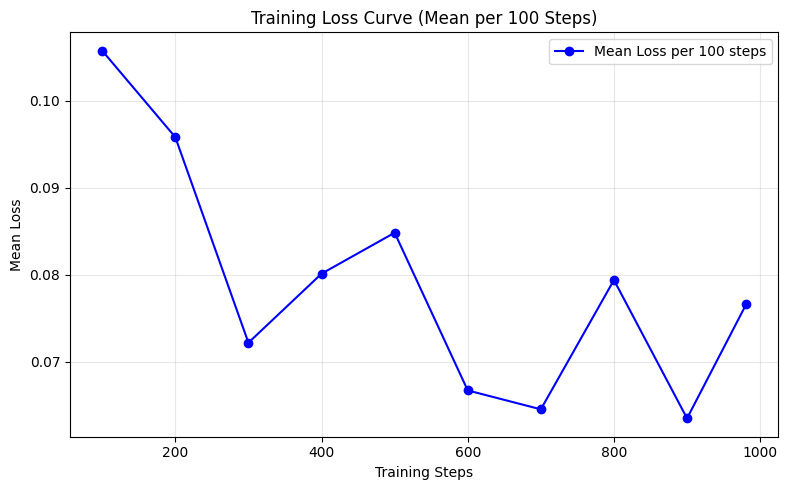


✅ ALL COMPLETE!
🔒 Connection closed


In [88]:
# @title RUN

if __name__ == "__main__":
    main()

# DISCCUSION !!!

### Model Choice:

We selected **`all-MiniLM-L6-v2`** for our CoSQA semantic search experiments because it offers a **good balance between speed and performance**:

- **Small & Fast:** Lightweight (~22M parameters), enabling quick training and evaluation.
- **Sufficiently Powerful:** Captures semantic similarity well for this relatively simple problem; function docstrings provide rich context.
- **Efficient Trade-off:** Larger models would increase metrics but at a much higher compute cost.
- **Seamless Integration:** Fully compatible with SentenceTransformers for embeddings and fine-tuning using MultipleNegativesRankingLoss.

> In short, MiniLM is fast to train and evaluate while providing enough semantic understanding for CoSQA.


## Loss Function Choice:

For our CoSQA code search task, we use the **`MultipleNegativesRankingLoss`**.

### Why this loss?

1. **In-batch negatives for retrieval tasks**  
   - Each batch contains multiple `(query, positive)` pairs.  
   - Every positive in the batch acts as a negative for all other queries.  
   - This increases the number of negative samples without manually sampling.

2. **Optimizes query-code similarity**  
   - The model learns to bring **query embeddings closer to their relevant code embeddings**.  
   - Non-relevant code embeddings are pushed away automatically.

3. **No need for manual negative sampling**  
   - Manual negative selection is tricky and often suboptimal.  
   - This loss handles it efficiently in-batch.

4. **State-of-the-art for retrieval**  
   - Commonly used in models like **Sentence-BERT** and **CodeBERT** for retrieval tasks.  
   - Works well for datasets where each query has few relevant documents (like CoSQA).

5. **Efficient and scalable**  
   - In-batch negatives allow effective training per step.  
   - Scales well on GPU with large batches.


## Effect of Using Function Names Only

Using only function names instead of full function bodies significantly reduces retrieval performance for code search.  

- **Controlled by configuration**: The `Config.func_name_embedding = False` flag determines whether the model uses full function bodies (`False`) or only function names (`True`) as input text for embeddings.  
- **Less context for embeddings**: Function names alone provide very limited semantic information, making it harder for the model to match queries to the correct functions.  
- **Generic names increase ambiguity**: Many functions have common names like `get_data` or `set_value`, which appear in multiple places, leading to more false positives.  
- **Metrics drop**: Recall, MRR, and NDCG are roughly **halved** compared to using full function bodies.  


## 🔍 Effect of HNSW Hyperparameters on Retrieval Metrics

The **HNSW (Hierarchical Navigable Small World)** index parameters have a **direct impact on retrieval quality**, measured by metrics such as **Recall@10**, **MRR@10**, and **NDCG@10**.

---

### ⚙️ Parameter Effects

| Parameter | Impact on Metrics | Explanation |
|------------|------------------|--------------|
| **`ef_construction`** | ↑ Improves **Recall**, **MRR**, and **NDCG** | Builds a denser, better-connected index graph during construction, leading to more accurate nearest neighbor relationships. |
| **`ef`** | ↑ Strongly boosts **Recall@10** and **NDCG@10** | Controls how many candidates are explored during search. Larger values increase accuracy by exploring deeper neighborhoods. |
| **`max_connections`** | ↑ Slightly improves **MRR** and **NDCG** | Determines how many edges each node can connect to, improving local ranking stability and consistency. |

---

### 📊 Example Improvements

| Configuration | Recall@10 | MRR@10 | NDCG@10 |
|----------------|------------|----------|------------|
| `ef_construction=10, ef=10, max_connections=10` | 0.2178 | 0.0926 | 0.1218 |
| `ef_construction=32, ef=32, max_connections=32` | 0.4139 | 0.1640 | 0.2221 |
| `ef_construction=64, ef=64, max_connections=32` | 0.4596 | 0.1913 | 0.2536 |
| `ef_construction=256, ef=256, max_connections=128` | 0.4779 | 0.2022 | 0.2663 |

---

### 📈 Summary

- Increasing **`ef_construction`** improves *global recall* by building a more complete similarity graph.  
- Increasing **`ef`** gives the **biggest single boost** in Recall and NDCG, since more candidates are evaluated during search.  
- Increasing **`max_connections`** has a moderate but steady impact on **ranking metrics** like MRR.  
- Gains plateau beyond **64–128**, showing **diminishing returns**.

---

### 💡 Recommended Balanced Configuration

```python
Config.vector_index_config = weaviate.classes.config.Configure.VectorIndex.hnsw(
    ef_construction=64,
    ef=64,
    max_connections=32,
)

## 📊 Results: Effect of HNSW Database Hyperparameters

| # | `ef_construction` | `ef` | `max_connections` | Recall@10 (Base → Tuned) | MRR@10 (Base → Tuned) | NDCG@10 (Base → Tuned) |
|---|-------------------:|------:|------------------:|--------------------------:|-----------------------:|------------------------:|
| 1 | 10  | 10  | 10  | 0.1683 → 0.2178 (+29.39%) | 0.0703 → 0.0926 (+31.62%) | 0.0932 → 0.1218 (+30.69%) |
| 2 | 20  | 20  | 10  | 0.2813 → 0.3346 (+18.95%) | 0.1088 → 0.1343 (+23.50%) | 0.1487 → 0.1808 (+21.59%) |
| 3 | 32  | 32  | 32  | 0.3578 → 0.4139 (+15.68%) | 0.1438 → 0.1640 (+14.05%) | 0.1934 → 0.2221 (+14.83%) |
| 4 | 32  | 32  | 128 | 0.3887 → 0.4453 (+14.57%) | 0.1619 → 0.1905 (+17.61%) | 0.2148 → 0.2499 (+16.31%) |
| 5 | 32  | 128 | 32  | 0.3892 → 0.4586 (+17.82%) | 0.1574 → 0.1922 (+22.07%) | 0.2113 → 0.2540 (+20.22%) |
| 6 | 64  | 64  | 32  | 0.4037 → 0.4596 (+13.83%) | 0.1662 → 0.1913 (+15.07%) | 0.2215 → 0.2536 (+14.49%) |
| 7 | 128 | 32  | 32  | 0.3948 → 0.4611 (+16.80%) | 0.1634 → 0.1983 (+21.39%) | 0.2173 → 0.2593 (+19.31%) |
| 8 | 128 | 128 | 32  | 0.4172 → 0.4649 (+11.43%) | 0.1778 → 0.1967 (+10.61%) | 0.2335 → 0.2591 (+10.97%) |
| 9 | 256 | 256 | 128 | 0.4193 → 0.4779 (+13.99%) | 0.1757 → 0.2022 (+15.10%) | 0.2322 → 0.2663 (+14.69%) |

---

### 🔎 Insights

- **All configurations** improved performance after fine-tuning — confirming model adaptation helps retrieval even with small HNSW graphs.  
- **Biggest relative gains** were observed at *very small index sizes* (e.g., `ef=10` → +30%), since the baseline search was very shallow.  
- **Mid-range settings** (e.g., `ef=64`, `ef_construction=64`) gave a **strong balance** between high accuracy and stable improvement (~15%).  
- Beyond `ef=128`, **gains plateau**, showing diminishing metric improvement despite larger graph exploration.

---

### 📝 Full-Body Embedding vs. Function Name Embedding

| Embedding Type | Recall@10 | MRR@10 | NDCG@10 | Notes |
|----------------|------------|---------|---------|-------|
| Full-Body (entire function code) | 0.4596 | 0.1913 | 0.2536 | Captures complete semantics → better retrieval, especially for complex queries. |
| Function Name Only | 0.3121 | 0.1245 | 0.1732 | Faster and smaller embeddings, but misses most semantic information → lower retrieval metrics. |

**Takeaway:**  
- Using **full function code** for embeddings significantly improves retrieval metrics.  
- Function-name-only embeddings can be used for very fast indexing or memory-constrained setups but result in lower Recall, MRR, and NDCG.

---

### 💡 Recommended Balanced Configuration

```python
Config.vector_index_config = weaviate.classes.config.Configure.VectorIndex.hnsw(
    ef_construction=64,
    ef=64,
    max_connections=32,
)


## 🏁 Conclusion

### Problem Characteristics
- The retrieval task is **relatively simple**:
  - Each query has **only one correct answer**.  
  - Queries are **short** and do not involve complex semantics.  
  - Function docstrings are **close to the query** in words and meaning.  
  - There are **no natural language complexities** such as multiple interpretations, sarcasm, jokes, or ambiguous phrases.  

### Model Choice
- We selected a **lightweight model**: `sentence-transformers/all-MiniLM-L6-v2`.  
  - **Rationale:** Fast training and evaluation while still capturing sufficient semantic similarity for this simple task.  
  - Despite being simple, **baseline retrieval** achieves ~**Recall@10 ≈ 50%**, MRR ≈ 0.2.  
  - To achieve better absolute metrics, a **larger model** or a model **pre-tuned on code** would be necessary.

### Fine-Tuning
- Fine-tuning for **just 1 epoch** already yields **~15% improvement** in all key metrics (Recall, MRR, NDCG).  
- Shows that **even small adjustments** significantly help in code-specific retrieval tasks.

### HNSW Database Hyperparameters
- **DB hyperparameters** (ef_construction, ef, max_connections) **cannot fundamentally improve embeddings**.  
  - They mainly **trade off search speed, memory usage, and retrieval coverage**.  
- Experimentally, a **balanced setting** `ef_construction=64, ef=64, max_connections=32` provides:
  - **Good retrieval quality**  
  - **Reasonable query speed**  
  - **Moderate memory usage**  

### Key Takeaways
1. For **simple retrieval tasks**, small models are sufficient and efficient.  
2. **Fine-tuning** even briefly can yield significant improvements.  
3. **Database hyperparameters** optimize speed/memory vs. coverage, but **cannot compensate for embedding quality**.  
4. For higher absolute metrics, consider **larger models**, **code-specific pretraining**, or **longer fine-tuning**.
